# Baseline Modeling and Feature Engineering

Notebook to explore the unsecured loan dataset, build feature engineering, and train baseline CatBoost, XGBoost, and LightGBM models with ROC AUC evaluation.


In [201]:
pip install catboost


Note: you may need to restart the kernel to use updated packages.


In [202]:
pip install xgboost 


Note: you may need to restart the kernel to use updated packages.


In [203]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [204]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [205]:
import os
import subprocess

try:
    gpu_check = subprocess.run(["nvidia-smi"], capture_output=True, text=True)
    USE_GPU = gpu_check.returncode == 0
except FileNotFoundError:
    USE_GPU = False

print(f"GPU available: {USE_GPU}")


GPU available: True


Enable GPU in Kaggle notebook settings (Runtime ➝ Change runtime type ➝ T4 GPU) for faster CatBoost/XGBoost/LightGBM training. The code auto-detects the GPU and switches booster backends accordingly.


In [206]:
train = pd.read_csv("/kaggle/input/triantestorg/train.csv")
test = pd.read_csv("/kaggle/input/triantestorg/test.csv")
sample_submission = pd.read_csv('/kaggle/input/sample-submission/sample_submission.csv')
train.shape, test.shape


((80000, 31), (20000, 30))

In [207]:
train['JIS Address Code'] = train['JIS Address Code'].fillna(-999).astype(int)
test['JIS Address Code'] = test['JIS Address Code'].fillna(-999).astype(int)


In [208]:
# Date & Time Engineering
train['Application Date'] = pd.to_datetime(train['Application Date'])
train['Date of Birth'] = pd.to_datetime(train['Date of Birth'])
test['Application Date'] = pd.to_datetime(test['Application Date'])
test['Date of Birth'] = pd.to_datetime(test['Date of Birth'])

# Age at application (HUGE feature)
train['Age'] = (train['Application Date'] - train['Date of Birth']).dt.days / 365.25
test['Age'] = (test['Application Date'] - test['Date of Birth']).dt.days / 365.25

# Application timing features
train['Application_Month'] = train['Application Date'].dt.month
train['Application_DayOfWeek'] = train['Application Date'].dt.dayofweek
test['Application_Month'] = test['Application Date'].dt.month
test['Application_DayOfWeek'] = test['Application Date'].dt.dayofweek

# Application Hour
train['Application_Hour'] = train['Application Time'] // 10000
test['Application_Hour'] = test['Application Time'] // 10000

print("✅ Date/Time features created")


✅ Date/Time features created


In [209]:
# Financial Ratio Engineering
epsilon = 1e-6

# Loan to income ratio
train['LOAN_TO_INCOME_RATIO'] = train['Application Limit Amount(Desired)'] / (train['Total Annual Income'] + epsilon)
test['LOAN_TO_INCOME_RATIO'] = test['Application Limit Amount(Desired)'] / (test['Total Annual Income'] + epsilon)

# Debt to income ratios
train['DECLARED_DEBT_TO_INCOME_RATIO'] = train['Declared Amount of Unsecured Loans'] / (train['Total Annual Income'] + epsilon)
test['DECLARED_DEBT_TO_INCOME_RATIO'] = test['Declared Amount of Unsecured Loans'] / (test['Total Annual Income'] + epsilon)

train['ACTUAL_DEBT_TO_INCOME_RATIO'] = train['Amount of Unsecured Loans'] / (train['Total Annual Income'] + epsilon)
test['ACTUAL_DEBT_TO_INCOME_RATIO'] = test['Amount of Unsecured Loans'] / (test['Total Annual Income'] + epsilon)

# Monthly debt to income (more accurate)
train['MONTHLY_INCOME'] = train['Total Annual Income'] / 12
test['MONTHLY_INCOME'] = test['Total Annual Income'] / 12

train['MONTHLY_DEBT_TO_INCOME'] = train['Amount of Unsecured Loans'] / (train['MONTHLY_INCOME'] + epsilon)
test['MONTHLY_DEBT_TO_INCOME'] = test['Amount of Unsecured Loans'] / (test['MONTHLY_INCOME'] + epsilon)

# Did they lie? (GIGANTIC red flag)
train['DEBT_DISCREPANCY_AMOUNT'] = train['Amount of Unsecured Loans'] - train['Declared Amount of Unsecured Loans']
test['DEBT_DISCREPANCY_AMOUNT'] = test['Amount of Unsecured Loans'] - test['Declared Amount of Unsecured Loans']

train['DEBT_DISCREPANCY_COUNT'] = train['Number of Unsecured Loans'] - train['Declared Number of Unsecured Loans']
test['DEBT_DISCREPANCY_COUNT'] = test['Number of Unsecured Loans'] - test['Declared Number of Unsecured Loans']

train['DEBT_DISCREPANCY_RATIO'] = train['DEBT_DISCREPANCY_AMOUNT'] / (train['Declared Amount of Unsecured Loans'] + epsilon)
test['DEBT_DISCREPANCY_RATIO'] = test['DEBT_DISCREPANCY_AMOUNT'] / (test['Declared Amount of Unsecured Loans'] + epsilon)

# Income per person
train['DEPENDENTS_TOTAL'] = train['Number of Dependents'] + train['Number of Dependent Children']
test['DEPENDENTS_TOTAL'] = test['Number of Dependents'] + test['Number of Dependent Children']

train['INCOME_PER_DEPENDENT'] = train['Total Annual Income'] / (train['DEPENDENTS_TOTAL'] + 1)
test['INCOME_PER_DEPENDENT'] = test['Total Annual Income'] / (test['DEPENDENTS_TOTAL'] + 1)

train['INCOME_PER_CHILD'] = train['Total Annual Income'] / (train['Number of Dependent Children'] + 1)
test['INCOME_PER_CHILD'] = test['Total Annual Income'] / (test['Number of Dependent Children'] + 1)

# Average loan amount
train['AVG_LOAN_AMOUNT_ACTUAL'] = train['Amount of Unsecured Loans'] / (train['Number of Unsecured Loans'] + epsilon)
test['AVG_LOAN_AMOUNT_ACTUAL'] = test['Amount of Unsecured Loans'] / (test['Number of Unsecured Loans'] + epsilon)

# Declared vs actual loan count ratio
train['LOAN_COUNT_RATIO'] = train['Number of Unsecured Loans'] / (train['Declared Number of Unsecured Loans'] + epsilon)
test['LOAN_COUNT_RATIO'] = test['Number of Unsecured Loans'] / (test['Declared Number of Unsecured Loans'] + epsilon)

# Rent to income ratio (monthly)
train['RENT_TO_MONTHLY_INCOME'] = train['Rent Burden Amount'] / (train['MONTHLY_INCOME'] + epsilon)
test['RENT_TO_MONTHLY_INCOME'] = test['Rent Burden Amount'] / (test['MONTHLY_INCOME'] + epsilon)

# Total monthly burden
train['TOTAL_MONTHLY_BURDEN'] = train['Rent Burden Amount'] + (train['Amount of Unsecured Loans'] / 12)
test['TOTAL_MONTHLY_BURDEN'] = test['Rent Burden Amount'] + (test['Amount of Unsecured Loans'] / 12)

train['TOTAL_BURDEN_TO_INCOME'] = train['TOTAL_MONTHLY_BURDEN'] / (train['MONTHLY_INCOME'] + epsilon)
test['TOTAL_BURDEN_TO_INCOME'] = test['TOTAL_MONTHLY_BURDEN'] / (test['MONTHLY_INCOME'] + epsilon)

print("✅ Financial ratio features created")


✅ Financial ratio features created


In [210]:
# Keep only essential stability features (remove noise)

# Employment stability
train['EMPLOYMENT_DURATION_YEARS'] = train['Duration of Employment at Company (Months)'] / 12
test['EMPLOYMENT_DURATION_YEARS'] = test['Duration of Employment at Company (Months)'] / 12

train['EMPLOYMENT_STABILITY'] = train['EMPLOYMENT_DURATION_YEARS'] / (train['Age'] + epsilon)
test['EMPLOYMENT_STABILITY'] = test['EMPLOYMENT_DURATION_YEARS'] / (test['Age'] + epsilon)

# Age buckets (keep as categorical)
train['AGE_BUCKET'] = pd.cut(train['Age'], bins=[0, 25, 35, 45, 55, 100], labels=[0, 1, 2, 3, 4]).astype(int)
test['AGE_BUCKET'] = pd.cut(test['Age'], bins=[0, 25, 35, 45, 55, 100], labels=[0, 1, 2, 3, 4]).astype(int)

print("✅ Simplified stability features created (removed frequency encoding noise)")


✅ Simplified stability features created (removed frequency encoding noise)


In [211]:
# Phase 6: Advanced Interaction Features

# 1. Stability Profile
train['STABILITY_RATIO'] = train['Duration of Employment at Company (Months)'] / (train['Age'] * 12 + epsilon)
test['STABILITY_RATIO'] = test['Duration of Employment at Company (Months)'] / (test['Age'] * 12 + epsilon)

# 2. Financial Burden Profile
train['RENT_BURDEN_PER_PERSON'] = train['Rent Burden Amount'] / (train['INCOME_PER_DEPENDENT'] + epsilon)
test['RENT_BURDEN_PER_PERSON'] = test['Rent Burden Amount'] / (test['INCOME_PER_DEPENDENT'] + epsilon)

# 3. Income vs Age
train['INCOME_PER_AGE'] = train['Total Annual Income'] / (train['Age'] + epsilon)
test['INCOME_PER_AGE'] = test['Total Annual Income'] / (test['Age'] + epsilon)

# 4. Total Financial Weight
train['TOTAL_FINANCIAL_BURDEN_RATIO'] = (train['Rent Burden Amount'] + train['Amount of Unsecured Loans']) / (train['Total Annual Income'] + epsilon)
test['TOTAL_FINANCIAL_BURDEN_RATIO'] = (test['Rent Burden Amount'] + test['Amount of Unsecured Loans']) / (test['Total Annual Income'] + epsilon)

# 5. Loan Ambition
train['AMBITION_RATIO'] = train['Application Limit Amount(Desired)'] / (train['Amount of Unsecured Loans'] + epsilon)
test['AMBITION_RATIO'] = test['Application Limit Amount(Desired)'] / (test['Amount of Unsecured Loans'] + epsilon)

print("✅ Advanced interaction features created")


✅ Advanced interaction features created


In [212]:
# Phase 7: Relative Income Trick (Group Aggregation)

print("Starting Group Aggregation features...")

group_cols = ['Industry Type', 'Employment Type', 'JIS Address Code', 'Company Size Category']
agg_cols = ['Total Annual Income', 'Age', 'LOAN_TO_INCOME_RATIO']

for group_col in group_cols:
    for agg_col in agg_cols:
        # Calculate stats on train only
        stats = train.groupby(group_col)[agg_col].agg(['mean', 'max', 'min']).reset_index()
        
        # Rename columns after aggregation
        stats.columns = [group_col, 'mean', 'max', 'min']
        
        # Merge to train
        train = train.merge(stats, on=group_col, how='left', suffixes=('', '_agg'))
        
        # Create relative feature (THE GOLD)
        train[f'{agg_col}_RELATIVE_to_{group_col}'] = train[agg_col] / (train['mean'] + epsilon)
        
        # Merge to test
        test = test.merge(stats, on=group_col, how='left', suffixes=('', '_agg'))
        test[f'{agg_col}_RELATIVE_to_{group_col}'] = test[agg_col] / (test['mean'] + epsilon)
        
        # Clean up
        train = train.drop(columns=['mean', 'max', 'min'])
        test = test.drop(columns=['mean', 'max', 'min'])

print("✅ Group Aggregation features created")


Starting Group Aggregation features...
✅ Group Aggregation features created


## 🚀 PHASE 1 IMPROVEMENTS

### New Features (Expected: +0.040 AUC):
1. Enhanced Debt Deception (5 features)
2. Domain Risk Scores (9 features)
3. Target Encoding (7 features)

In [213]:
# PHASE 1.1: Enhanced Debt Deception Features
def create_enhanced_debt_deception(df):
    epsilon = 1e-6
    
    # 1. Deception Severity Score (0-10)
    df['DEBT_DECEPTION_SEVERITY'] = (
        (np.abs(df['DEBT_DISCREPANCY_AMOUNT']) / (df['Total Annual Income'] + epsilon)).clip(0, 1) * 3 +
        np.abs(df['DEBT_DISCREPANCY_RATIO']).clip(0, 2) * 1 +
        np.abs(df['DEBT_DISCREPANCY_COUNT']).clip(0, 3) * 1 +
        ((df['DEBT_DISCREPANCY_AMOUNT'] > 0) * 
         (df['DEBT_DISCREPANCY_AMOUNT'] / (df['Total Annual Income'] + epsilon)).clip(0, 1) * 2)
    ).clip(0, 10)
    
    # 2. Declared Zero but Has Debt (RED FLAG!)
    df['DECLARED_ZERO_HAS_DEBT'] = (
        (df['Declared Amount of Unsecured Loans'] == 0) & 
        (df['Amount of Unsecured Loans'] > 0)
    ).astype(int)
    
    # 3. Under-reported Severely
    df['UNDER_REPORTED_SEVERE'] = (
        df['DEBT_DISCREPANCY_AMOUNT'] > (df['Total Annual Income'] * 0.1)
    ).astype(int)
    
    # 4. Few loans but large amount (suspicious)
    df['FEW_LOANS_LARGE_AMOUNT'] = (
        (df['Declared Number of Unsecured Loans'] <= 1) &
        (df['Declared Amount of Unsecured Loans'] > df['Total Annual Income'] * 0.3)
    ).astype(int)
    
    # 5. Deception Pattern Category
    df['DEBT_DECEPTION_PATTERN'] = 0
    df.loc[df['DEBT_DECEPTION_SEVERITY'] > 1, 'DEBT_DECEPTION_PATTERN'] = 1
    df.loc[df['DEBT_DECEPTION_SEVERITY'] > 3, 'DEBT_DECEPTION_PATTERN'] = 2
    df.loc[df['DEBT_DECEPTION_SEVERITY'] > 6, 'DEBT_DECEPTION_PATTERN'] = 3
    
    return df

train = create_enhanced_debt_deception(train)
test = create_enhanced_debt_deception(test)

print('✅ Enhanced Debt Deception features created (5 new)')
print(f'   Declared zero but has debt: {train["DECLARED_ZERO_HAS_DEBT"].sum()} cases')
print(f'   Severe under-reporting: {train["UNDER_REPORTED_SEVERE"].sum()} cases')


✅ Enhanced Debt Deception features created (5 new)
   Declared zero but has debt: 8047 cases
   Severe under-reporting: 8282 cases


In [214]:
# PHASE 1.2: Domain-Specific Risk Scores
def create_domain_risk_scores(df):
    # Employment Stability Score (0-5)
    employment_map = {1: 5, 2: 4, 3: 2, 4: 1, 5: 2}
    df['EMPLOYMENT_STABILITY_SCORE'] = df['Employment Type'].map(employment_map).fillna(1)
    
    # Company Stability Score (0-5)
    company_map = {1: 5, 2: 4, 3: 3, 4: 2, 5: 2, 6: 1, 7: 1, 8: 0, 9: 0}
    df['COMPANY_STABILITY_SCORE'] = df['Company Size Category'].map(company_map).fillna(0)
    
    # Residence Stability Score (0-5)
    residence_map = {1: 5, 2: 4, 8: 4, 9: 3, 3: 3, 4: 2, 5: 2, 6: 1, 7: 1}
    df['RESIDENCE_STABILITY_SCORE'] = df['Residence Type'].map(residence_map).fillna(1)
    
    # Channel Quality Score (0-3)
    channel_map = {1: 3, 4: 2, 2: 1, 3: 0, 0: 2, 99: 1}
    df['CHANNEL_QUALITY_SCORE'] = df['Internet Details'].map(channel_map).fillna(1)
    
    # Composite employment risk
    df['OVERALL_EMPLOYMENT_RISK'] = (
        df['EMPLOYMENT_STABILITY_SCORE'] * 0.4 + df['COMPANY_STABILITY_SCORE'] * 0.6
    )
    
    # Binary flags
    df['IS_PUBLIC_EMPLOYEE'] = (df['Company Size Category'] == 1).astype(int)
    df['IS_SOLE_PROPRIETOR'] = (df['Company Size Category'] == 9).astype(int)
    df['IS_HOME_OWNER'] = df['Residence Type'].isin([1, 2, 8, 9]).astype(int)
    df['IS_ORGANIC_LEAD'] = (df['Internet Details'] == 1).astype(int)
    
    return df

train = create_domain_risk_scores(train)
test = create_domain_risk_scores(test)

print('✅ Domain Risk Scores created (9 new)')
print(f'   Public employees: {train["IS_PUBLIC_EMPLOYEE"].sum()} ({train["IS_PUBLIC_EMPLOYEE"].mean()*100:.1f}%)')
print(f'   Home owners: {train["IS_HOME_OWNER"].sum()} ({train["IS_HOME_OWNER"].mean()*100:.1f}%)')
print(f'   Organic leads: {train["IS_ORGANIC_LEAD"].sum()} ({train["IS_ORGANIC_LEAD"].mean()*100:.1f}%)')


✅ Domain Risk Scores created (9 new)
   Public employees: 2348 (2.9%)
   Home owners: 35362 (44.2%)
   Organic leads: 18980 (23.7%)


In [215]:
# PHASE 1.3: Target Encoding (K-Fold to prevent leakage)
from sklearn.model_selection import KFold

def target_encode_kfold(train_df, test_df, target_col, feature_cols, n_splits=5, smoothing=10):
    global_mean = train_df[target_col].mean()
    encoded_train = train_df.copy()
    encoded_test = test_df.copy()
    
    for col in feature_cols:
        print(f'  Encoding {col}... (unique: {train_df[col].nunique()})')
        encoded_train[f'{col}_TARGET_ENC'] = global_mean
        
        # K-Fold encoding for train
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        for train_idx, val_idx in kf.split(train_df):
            train_fold = train_df.iloc[train_idx]
            stats = train_fold.groupby(col)[target_col].agg(['mean', 'count']).reset_index()
            stats.columns = [col, 'mean', 'count']
            stats['smoothed'] = (stats['count'] * stats['mean'] + smoothing * global_mean) / (stats['count'] + smoothing)
            mapping = dict(zip(stats[col], stats['smoothed']))
            encoded_train.loc[val_idx, f'{col}_TARGET_ENC'] = train_df.iloc[val_idx][col].map(mapping).fillna(global_mean)
        
        # For test, use full train
        stats_full = train_df.groupby(col)[target_col].agg(['mean', 'count']).reset_index()
        stats_full.columns = [col, 'mean', 'count']
        stats_full['smoothed'] = (stats_full['count'] * stats_full['mean'] + smoothing * global_mean) / (stats_full['count'] + smoothing)
        mapping_test = dict(zip(stats_full[col], stats_full['smoothed']))
        encoded_test[f'{col}_TARGET_ENC'] = test_df[col].map(mapping_test).fillna(global_mean)
    
    return encoded_train, encoded_test

# Features to encode (top importance + high cardinality)
target_encode_features = [
    'JIS Address Code', 'Industry Type', 'Company Size Category',
    'Insurance Job Type', 'Reception Type Category', 'Employment Type', 'Major Media Code'
]

print('🎯 TARGET ENCODING (K-fold with smoothing=10)')
print(f'Global default rate: {train["Default 12 Flag"].mean():.4f}')
train, test = target_encode_kfold(train, test, 'Default 12 Flag', target_encode_features)
print('✅ Target encoding complete (7 new features)')


🎯 TARGET ENCODING (K-fold with smoothing=10)
Global default rate: 0.0991
  Encoding JIS Address Code... (unique: 1803)
  Encoding Industry Type... (unique: 18)
  Encoding Company Size Category... (unique: 9)
  Encoding Insurance Job Type... (unique: 4)
  Encoding Reception Type Category... (unique: 9)
  Encoding Employment Type... (unique: 5)
  Encoding Major Media Code... (unique: 9)
✅ Target encoding complete (7 new features)


## ⚡ PHASE 2: ADVANCED FEATURES

Adding:
1. Advanced Financial Ratios (6 features)
2. Temporal Risk Patterns (7 features)
3. Category Interactions (10 features)

**Expected additional gain: +0.020-0.030 AUC**

In [216]:
# PHASE 2.1: Advanced Financial Ratios
def create_advanced_financial_features(df):
    epsilon = 1e-6
    
    # 1. Debt Service Ratio (estimate monthly payment)
    # Assume 15% APR, 5-year term → monthly payment ≈ 2.38% of principal
    monthly_payment_rate = 0.0238
    df['ESTIMATED_MONTHLY_DEBT_PAYMENT'] = df['Amount of Unsecured Loans'] * monthly_payment_rate
    df['DEBT_SERVICE_RATIO'] = df['ESTIMATED_MONTHLY_DEBT_PAYMENT'] / (df['MONTHLY_INCOME'] + epsilon)
    
    # 2. Available Income After All Obligations
    df['AVAILABLE_INCOME_MONTHLY'] = (
        df['MONTHLY_INCOME'] - 
        df['ESTIMATED_MONTHLY_DEBT_PAYMENT'] - 
        df['Rent Burden Amount']
    )
    df['AVAILABLE_INCOME_RATIO'] = df['AVAILABLE_INCOME_MONTHLY'] / (df['MONTHLY_INCOME'] + epsilon)
    
    # 3. Potential DTI if loan approved
    df['POTENTIAL_TOTAL_DEBT'] = df['Amount of Unsecured Loans'] + df['Application Limit Amount(Desired)']
    df['POTENTIAL_DTI'] = df['POTENTIAL_TOTAL_DEBT'] / (df['Total Annual Income'] + epsilon)
    
    # 4. Overburden Risk Flag (DTI > 50%)
    df['OVERBURDEN_RISK'] = (df['POTENTIAL_DTI'] > 0.5).astype(int)
    
    # 5. Loan Request vs Existing Debt Pattern
    df['LOAN_REQUEST_TO_EXISTING'] = df['Application Limit Amount(Desired)'] / (df['Amount of Unsecured Loans'] + epsilon)
    df['REQUESTING_LARGE_INCREASE'] = (df['LOAN_REQUEST_TO_EXISTING'] > 1.5).astype(int)
    
    return df

train = create_advanced_financial_features(train)
test = create_advanced_financial_features(test)

print('✅ Advanced Financial Ratios created (6 new)')
print(f'   Overburden risk cases: {train["OVERBURDEN_RISK"].sum()} ({train["OVERBURDEN_RISK"].mean()*100:.1f}%)')
print(f'   Mean debt service ratio: {train["DEBT_SERVICE_RATIO"].mean():.3f}')


✅ Advanced Financial Ratios created (6 new)
   Overburden risk cases: 3579 (4.5%)
   Mean debt service ratio: 0.031


In [217]:
# PHASE 2.2: Temporal Risk Patterns
def create_temporal_risk_features(df):
    # 1. Late night application risk
    df['IS_LATE_NIGHT'] = df['Application_Hour'].isin([22, 23, 0, 1, 2, 3, 4, 5]).astype(int)
    df['IS_VERY_LATE_NIGHT'] = df['Application_Hour'].isin([0, 1, 2, 3, 4]).astype(int)
    
    # 2. Weekend application
    df['IS_WEEKEND'] = (df['Application_DayOfWeek'] >= 5).astype(int)
    
    # 3. Year-end borrowing (desperate?)
    df['IS_YEAR_END'] = (df['Application_Month'] == 12).astype(int)
    df['IS_HOLIDAY_SEASON'] = df['Application_Month'].isin([12, 1]).astype(int)
    
    # 4. Application time risk score
    def get_time_risk(hour):
        if 9 <= hour <= 17:  # Business hours
            return 0
        elif 18 <= hour <= 21:  # Evening
            return 1
        else:  # Late night
            return 2
    
    df['APP_TIME_RISK_SCORE'] = df['Application_Hour'].apply(get_time_risk)
    
    # 5. Mobile app flag
    df['IS_MOBILE_APP'] = df['Reception Type Category'].isin([1701, 1801]).astype(int)
    
    # 6. Risky combination: Mobile + Late night (impulse?)
    df['MOBILE_LATE_NIGHT'] = (
        (df['IS_MOBILE_APP'] == 1) & (df['IS_LATE_NIGHT'] == 1)
    ).astype(int)
    
    return df

train = create_temporal_risk_features(train)
test = create_temporal_risk_features(test)

print('✅ Temporal Risk Patterns created (7 new)')
print(f'   Late night apps: {train["IS_LATE_NIGHT"].sum()} ({train["IS_LATE_NIGHT"].mean()*100:.1f}%)')
print(f'   Weekend apps: {train["IS_WEEKEND"].sum()} ({train["IS_WEEKEND"].mean()*100:.1f}%)')
print(f'   Mobile + Late night: {train["MOBILE_LATE_NIGHT"].sum()} ({train["MOBILE_LATE_NIGHT"].mean()*100:.1f}%)')


✅ Temporal Risk Patterns created (7 new)
   Late night apps: 8052 (10.1%)
   Weekend apps: 20696 (25.9%)
   Mobile + Late night: 7067 (8.8%)


In [218]:
# PHASE 2.3: Category Interactions
def create_category_interactions(df):
    epsilon = 1e-6
    
    # 1. Employment × Company Risk Profiles
    df['STABLE_JOB_LARGE_COMPANY'] = (
        (df['Employment Type'].isin([1, 2])) &  # President/Employee
        (df['Company Size Category'].isin([1, 2, 3]))  # Public/Listed/Large
    ).astype(int)
    
    df['UNSTABLE_JOB_SMALL_COMPANY'] = (
        (df['Employment Type'].isin([3, 4])) &  # Contract/Part-time
        (df['Company Size Category'].isin([7, 8, 9]))  # Very small/Sole
    ).astype(int)
    
    # 2. Residence × Marital Stability
    df['MARRIED_HOMEOWNER'] = (
        (df['Single/Married Status'] == 2) &
        (df['IS_HOME_OWNER'] == 1)
    ).astype(int)
    
    df['SINGLE_RENTER'] = (
        (df['Single/Married Status'] == 1) &
        (df['IS_HOME_OWNER'] == 0)
    ).astype(int)
    
    # 3. Employment × Financial Risk
    df['STABLE_JOB_LOW_DEBT'] = (
        (df['OVERALL_EMPLOYMENT_RISK'] >= 3) &
        (df['ACTUAL_DEBT_TO_INCOME_RATIO'] < 0.2)
    ).astype(int)
    
    df['UNSTABLE_JOB_HIGH_DEBT'] = (
        (df['OVERALL_EMPLOYMENT_RISK'] <= 2) &
        (df['ACTUAL_DEBT_TO_INCOME_RATIO'] > 0.4)
    ).astype(int)
    
    # 4. Channel × Financial Behavior
    df['ORGANIC_LOW_DEBT'] = (
        (df['IS_ORGANIC_LEAD'] == 1) &
        (df['ACTUAL_DEBT_TO_INCOME_RATIO'] < 0.3)
    ).astype(int)
    
    df['AFFILIATE_HIGH_DEBT'] = (
        (df['Internet Details'] == 3) &  # Affiliate
        (df['ACTUAL_DEBT_TO_INCOME_RATIO'] > 0.4)
    ).astype(int)
    
    # 5. Mobile + Timing + Financial
    df['MOBILE_IMPULSIVE'] = (
        (df['IS_MOBILE_APP'] == 1) &
        (df['IS_LATE_NIGHT'] == 1) &
        (df['LOAN_TO_INCOME_RATIO'] > 0.5)
    ).astype(int)
    
    # 6. Age × Employment × Financial
    df['YOUNG_UNSTABLE_HIGH_DEBT'] = (
        (df['Age'] < 30) &
        (df['OVERALL_EMPLOYMENT_RISK'] <= 2) &
        (df['ACTUAL_DEBT_TO_INCOME_RATIO'] > 0.3)
    ).astype(int)
    
    # 7. Deception × Financial Risk
    df['LIAR_HIGH_DEBT'] = (
        (df['DEBT_DECEPTION_SEVERITY'] > 3) &
        (df['ACTUAL_DEBT_TO_INCOME_RATIO'] > 0.4)
    ).astype(int)
    
    return df

train = create_category_interactions(train)
test = create_category_interactions(test)

print('✅ Category Interactions created (10 new)')
print(f'   Married homeowners: {train["MARRIED_HOMEOWNER"].sum()} ({train["MARRIED_HOMEOWNER"].mean()*100:.1f}%)')
print(f'   Stable job + low debt: {train["STABLE_JOB_LOW_DEBT"].sum()} ({train["STABLE_JOB_LOW_DEBT"].mean()*100:.1f}%)')
print(f'   Unstable job + high debt: {train["UNSTABLE_JOB_HIGH_DEBT"].sum()} ({train["UNSTABLE_JOB_HIGH_DEBT"].mean()*100:.1f}%)')
print(f'   Liar + high debt: {train["LIAR_HIGH_DEBT"].sum()} ({train["LIAR_HIGH_DEBT"].mean()*100:.1f}%)')


✅ Category Interactions created (10 new)
   Married homeowners: 13160 (16.4%)
   Stable job + low debt: 12863 (16.1%)
   Unstable job + high debt: 1 (0.0%)
   Liar + high debt: 5 (0.0%)


In [219]:
# STRONGER financial features - make them impossible to ignore

# 1. Debt liar flag (strong signal - categorical)
train['DEBT_LIAR_FLAG'] = ((train['DEBT_DISCREPANCY_AMOUNT'] > 100000) | 
                            (train['DEBT_DISCREPANCY_COUNT'] > 1)).astype(int)
test['DEBT_LIAR_FLAG'] = ((test['DEBT_DISCREPANCY_AMOUNT'] > 100000) | 
                           (test['DEBT_DISCREPANCY_COUNT'] > 1)).astype(int)

# 2. High debt × multiple loans (interaction - very risky combo)
train['HIGH_DEBT_MULTI_LOAN'] = ((train['ACTUAL_DEBT_TO_INCOME_RATIO'] > 0.3) & 
                                   (train['Number of Unsecured Loans'] > 2)).astype(int)
test['HIGH_DEBT_MULTI_LOAN'] = ((test['ACTUAL_DEBT_TO_INCOME_RATIO'] > 0.3) & 
                                  (test['Number of Unsecured Loans'] > 2)).astype(int)

# 3. ULTRA-STRONG Financial risk score (combine ALL debt signals)
train['FIN_RISK_SCORE'] = (
    train['ACTUAL_DEBT_TO_INCOME_RATIO'] * 0.35 +
    train['LOAN_TO_INCOME_RATIO'] * 0.25 +
    train['DECLARED_DEBT_TO_INCOME_RATIO'] * 0.15 +
    (train['Number of Unsecured Loans'] / 5) * 0.15 +
    (np.abs(train['DEBT_DISCREPANCY_AMOUNT']) / (train['Total Annual Income'] + epsilon)).clip(0, 1) * 0.1
).clip(0, 10)
test['FIN_RISK_SCORE'] = (
    test['ACTUAL_DEBT_TO_INCOME_RATIO'] * 0.35 +
    test['LOAN_TO_INCOME_RATIO'] * 0.25 +
    test['DECLARED_DEBT_TO_INCOME_RATIO'] * 0.15 +
    (test['Number of Unsecured Loans'] / 5) * 0.15 +
    (np.abs(test['DEBT_DISCREPANCY_AMOUNT']) / (test['Total Annual Income'] + epsilon)).clip(0, 1) * 0.1
).clip(0, 10)

# Keep old one for compatibility
train['FIN_STRESS_COMPOSITE'] = train['FIN_RISK_SCORE']
test['FIN_STRESS_COMPOSITE'] = test['FIN_RISK_SCORE']

# 4. Debt × Employment interaction (employment is #1, debt is #7 - combine them!)
train['DEBT_X_EMP_DURATION'] = train['ACTUAL_DEBT_TO_INCOME_RATIO'] * np.log1p(train['Duration of Employment at Company (Months)'])
test['DEBT_X_EMP_DURATION'] = test['ACTUAL_DEBT_TO_INCOME_RATIO'] * np.log1p(test['Duration of Employment at Company (Months)'])

# 5. NEW: Debt × Loan Count (both are top features - combine!)
train['DEBT_X_LOAN_COUNT'] = train['ACTUAL_DEBT_TO_INCOME_RATIO'] * train['Number of Unsecured Loans']
test['DEBT_X_LOAN_COUNT'] = test['ACTUAL_DEBT_TO_INCOME_RATIO'] * test['Number of Unsecured Loans']

# 5b. Debt × AVG Loan Amount (combine #7 and #13 features)
train['DEBT_X_AVG_LOAN'] = train['ACTUAL_DEBT_TO_INCOME_RATIO'] * np.log1p(train['AVG_LOAN_AMOUNT_ACTUAL'])
test['DEBT_X_AVG_LOAN'] = test['ACTUAL_DEBT_TO_INCOME_RATIO'] * np.log1p(test['AVG_LOAN_AMOUNT_ACTUAL'])

# 6. NEW: High risk flag (multiple red flags)
train['MULTI_RISK_FLAG'] = (
    (train['ACTUAL_DEBT_TO_INCOME_RATIO'] > 0.4).astype(int) +
    (train['Number of Unsecured Loans'] > 3).astype(int) +
    (train['DEBT_DISCREPANCY_AMOUNT'] > 50000).astype(int)
).clip(0, 3)
test['MULTI_RISK_FLAG'] = (
    (test['ACTUAL_DEBT_TO_INCOME_RATIO'] > 0.4).astype(int) +
    (test['Number of Unsecured Loans'] > 3).astype(int) +
    (test['DEBT_DISCREPANCY_AMOUNT'] > 50000).astype(int)
).clip(0, 3)

print("✅ Stronger financial features created")


✅ Stronger financial features created


In [220]:
# Risk segmentation & binning
train['INCOME_BRACKET'] = pd.qcut(train['Total Annual Income'], q=10, labels=False, duplicates='drop').astype(int)
test['INCOME_BRACKET'] = pd.qcut(test['Total Annual Income'], q=10, labels=False, duplicates='drop').astype(int)

train['DEBT_BRACKET'] = pd.qcut(train['Amount of Unsecured Loans'].replace(0, np.nan), q=5, labels=False, duplicates='drop').fillna(0).astype(int)
test['DEBT_BRACKET'] = pd.qcut(test['Amount of Unsecured Loans'].replace(0, np.nan), q=5, labels=False, duplicates='drop').fillna(0).astype(int)

# Multi-risk composite score
train['COMPOSITE_RISK'] = (
    (train['ACTUAL_DEBT_TO_INCOME_RATIO'] > 0.4).astype(int) * 3 +
    (train['DEBT_DISCREPANCY_AMOUNT'] > 50000).astype(int) * 2 +
    (train['Number of Unsecured Loans'] > 3).astype(int) * 2 +
    (train['Age'] < 25).astype(int) * 1 +
    (train['EMPLOYMENT_DURATION_YEARS'] < 1).astype(int) * 1
)
test['COMPOSITE_RISK'] = (
    (test['ACTUAL_DEBT_TO_INCOME_RATIO'] > 0.4).astype(int) * 3 +
    (test['DEBT_DISCREPANCY_AMOUNT'] > 50000).astype(int) * 2 +
    (test['Number of Unsecured Loans'] > 3).astype(int) * 2 +
    (test['Age'] < 25).astype(int) * 1 +
    (test['EMPLOYMENT_DURATION_YEARS'] < 1).astype(int) * 1
)

# Income vs loan combinations (using log transform)
train['INCOME_LOAN_PRODUCT'] = np.log1p(train['Total Annual Income']) * np.log1p(train['Amount of Unsecured Loans'])
test['INCOME_LOAN_PRODUCT'] = np.log1p(test['Total Annual Income']) * np.log1p(test['Amount of Unsecured Loans'])

print("✅ Risk segmentation completed")


✅ Risk segmentation completed


In [221]:
# Phase 8: Polynomials & Non-Linearity

print("Starting Non-Linear features...")

# Log transforms
train['Total_Annual_Income_log'] = np.log1p(train['Total Annual Income'])
test['Total_Annual_Income_log'] = np.log1p(test['Total Annual Income'])

train['Application_Limit_log'] = np.log1p(train['Application Limit Amount(Desired)'])
test['Application_Limit_log'] = np.log1p(test['Application Limit Amount(Desired)'])

train['Amount_Unsecured_Loans_log'] = np.log1p(train['Amount of Unsecured Loans'])
test['Amount_Unsecured_Loans_log'] = np.log1p(test['Amount of Unsecured Loans'])

# Polynomial features
train['Age_sq'] = train['Age']**2
test['Age_sq'] = test['Age']**2

train['Duration_Employment_sq'] = train['Duration of Employment at Company (Months)']**2
test['Duration_Employment_sq'] = test['Duration of Employment at Company (Months)']**2

print("✅ Non-Linear features created")


Starting Non-Linear features...
✅ Non-Linear features created


In [222]:
# Categorical features - add new risk flagscategorical_features = [    'Major Media Code', 'Internet Details', 'Reception Type Category',    'Gender', 'Single/Married Status',    'Residence Type', 'Name Type', 'Family Composition Type',    'Living Arrangement Type', 'Insurance Job Type', 'Employment Type',    'Employment Status Type', 'Industry Type', 'Company Size Category',    'Application_Month', 'Application_DayOfWeek', 'Application_Hour',    'AGE_BUCKET', 'DEBT_DECEPTION_PATTERN', 'APP_TIME_RISK_SCORE', 'DEBT_LIAR_FLAG', 'HIGH_DEBT_MULTI_LOAN', 'MULTI_RISK_FLAG']for col in categorical_features:    train[col] = train[col].astype('category')    test[col] = test[col].astype('category')print(f"Categorical features: {len(categorical_features)}")

In [223]:
TARGET = 'Default 12 Flag'

# Balanced: Keep all features but strengthen financial ones
drop_cols = ['ID', TARGET, 'Application Date', 'Application Time', 'Date of Birth']

features = [col for col in train.columns if col not in drop_cols and col in train.columns]
# Filter out any columns that don't exist
features = [f for f in features if f in train.columns]

y = train[TARGET]
X = train[features]

print(f"Total features: {len(features)} (pruned from {len(train.columns)-1})")
print(f"Default rate: {y.mean()*100:.2f}%")
print(f"\nDropped overfitting features: {len(drop_cols)} columns")


Total features: 132 (pruned from 136)
Default rate: 9.91%

Dropped overfitting features: 5 columns


In [224]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [225]:
pip install optuna -q

Note: you may need to restart the kernel to use updated packages.


In [226]:
import optuna
from optuna.samplers import TPESampler

print('='*80)
print('🔥 FAST OPTUNA HYPERPARAMETER TUNING')
print('='*80)
print('\nStrategy: 10 trials, 1-fold validation (FAST!)')
print('Time: ~15-20 minutes\n')

def objective(trial):
    # Suggest hyperparameters
    params = {
        'iterations': 3000,  # Fixed, not too long
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.03, log=True),
        'depth': trial.suggest_int('depth', 6, 9),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 3, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 40),
        'subsample': trial.suggest_float('subsample', 0.6, 0.85),
        'eval_metric': 'AUC',
        'cat_features': categorical_features,
        'early_stopping_rounds': 200,
        'verbose': False,
        'random_state': 42,
        'task_type': 'GPU' if USE_GPU else 'CPU',
        'devices': '0' if USE_GPU else None,
        'bootstrap_type': 'Bernoulli',
        'boosting_type': 'Plain',
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 2.0, 3.5)
    }
    
    # Use 1 fold for speed (fast validation)
    skf_tune = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_idx, val_idx = next(skf_tune.split(X, y))
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
    
    preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)
    
    return auc

# Run optimization (10 trials = fast!)
print('Starting Optuna optimization...')
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)

study.optimize(objective, n_trials=10, show_progress_bar=True)

print('\n' + '='*80)
print('✅ OPTIMIZATION COMPLETE!')
print('='*80)
print(f'\nBest AUC: {study.best_value:.6f}')
print(f'Improvement: {study.best_value - 0.677756:+.6f}')
print(f'\nBest Hyperparameters:')
for key, value in study.best_params.items():
    print(f'  {key:25s}: {value}')

# Store best params for final training
best_params = study.best_params.copy()
best_params.update({
    'iterations': 3500,
    'eval_metric': 'AUC',
    'cat_features': categorical_features,
    'early_stopping_rounds': 200,
    'verbose': 100,
    'random_state': 42,
    'task_type': 'GPU' if USE_GPU else 'CPU',
    'devices': '0' if USE_GPU else None,
    'bootstrap_type': 'Bernoulli',
    'boosting_type': 'Plain'
})

print(f'\n📊 Best params saved for final training!')


[I 2025-11-08 16:33:44,705] A new study created in memory with name: no-name-c7d12143-ee49-46d3-8cd6-11406e6cc697


🔥 FAST OPTUNA HYPERPARAMETER TUNING

Strategy: 10 trials, 1-fold validation (FAST!)
Time: ~15-20 minutes

Starting Optuna optimization...


  0%|          | 0/10 [00:00<?, ?it/s]

Default metric period is 5 because AUC is/are not implemented for GPU


[I 2025-11-08 16:35:01,202] Trial 0 finished with value: 0.6801801474711692 and parameters: {'learning_rate': 0.015090410414033417, 'depth': 9, 'l2_leaf_reg': 8, 'min_data_in_leaf': 32, 'subsample': 0.6390046601106091, 'scale_pos_weight': 2.233991780504304}. Best is trial 0 with value: 0.6801801474711692.


Default metric period is 5 because AUC is/are not implemented for GPU


[I 2025-11-08 16:36:29,692] Trial 1 finished with value: 0.6830003704189094 and parameters: {'learning_rate': 0.010658913208222872, 'depth': 9, 'l2_leaf_reg': 7, 'min_data_in_leaf': 34, 'subsample': 0.6051461235739506, 'scale_pos_weight': 3.4548647782429915}. Best is trial 1 with value: 0.6830003704189094.


Default metric period is 5 because AUC is/are not implemented for GPU


[I 2025-11-08 16:37:01,420] Trial 2 finished with value: 0.6842693220179134 and parameters: {'learning_rate': 0.024956063227108884, 'depth': 6, 'l2_leaf_reg': 4, 'min_data_in_leaf': 23, 'subsample': 0.6760605607398844, 'scale_pos_weight': 2.7871346474483567}. Best is trial 2 with value: 0.6842693220179134.


Default metric period is 5 because AUC is/are not implemented for GPU


[I 2025-11-08 16:37:49,779] Trial 3 finished with value: 0.6818681168704029 and parameters: {'learning_rate': 0.016072748506390403, 'depth': 7, 'l2_leaf_reg': 7, 'min_data_in_leaf': 22, 'subsample': 0.6730361621338046, 'scale_pos_weight': 2.5495427649405373}. Best is trial 2 with value: 0.6842693220179134.


Default metric period is 5 because AUC is/are not implemented for GPU


[I 2025-11-08 16:38:48,052] Trial 4 finished with value: 0.6812362875451585 and parameters: {'learning_rate': 0.016504435816626584, 'depth': 9, 'l2_leaf_reg': 4, 'min_data_in_leaf': 30, 'subsample': 0.7481036422155106, 'scale_pos_weight': 2.0696756190799968}. Best is trial 2 with value: 0.6842693220179134.


Default metric period is 5 because AUC is/are not implemented for GPU


[I 2025-11-08 16:39:21,596] Trial 5 finished with value: 0.6825016959306938 and parameters: {'learning_rate': 0.019492725276287894, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 39, 'subsample': 0.8414080082686398, 'scale_pos_weight': 3.212596022174692}. Best is trial 2 with value: 0.6842693220179134.


Default metric period is 5 because AUC is/are not implemented for GPU


[I 2025-11-08 16:40:10,144] Trial 6 finished with value: 0.6838104540020027 and parameters: {'learning_rate': 0.013974545876676644, 'depth': 6, 'l2_leaf_reg': 8, 'min_data_in_leaf': 29, 'subsample': 0.6305095587111946, 'scale_pos_weight': 2.742765365166905}. Best is trial 2 with value: 0.6842693220179134.


Default metric period is 5 because AUC is/are not implemented for GPU


[I 2025-11-08 16:41:50,507] Trial 7 finished with value: 0.679562141052791 and parameters: {'learning_rate': 0.01038502375625752, 'depth': 9, 'l2_leaf_reg': 5, 'min_data_in_leaf': 33, 'subsample': 0.6779277690223527, 'scale_pos_weight': 2.780102031766716}. Best is trial 2 with value: 0.6842693220179134.


Default metric period is 5 because AUC is/are not implemented for GPU


[I 2025-11-08 16:42:33,377] Trial 8 finished with value: 0.6841738739711338 and parameters: {'learning_rate': 0.018232536617196038, 'depth': 6, 'l2_leaf_reg': 10, 'min_data_in_leaf': 36, 'subsample': 0.8348747353910473, 'scale_pos_weight': 3.3422410256414734}. Best is trial 2 with value: 0.6842693220179134.


Default metric period is 5 because AUC is/are not implemented for GPU


[I 2025-11-08 16:43:29,892] Trial 9 finished with value: 0.6819667144402659 and parameters: {'learning_rate': 0.019287271240439677, 'depth': 9, 'l2_leaf_reg': 3, 'min_data_in_leaf': 24, 'subsample': 0.6113068222276345, 'scale_pos_weight': 2.4879954961448965}. Best is trial 2 with value: 0.6842693220179134.

✅ OPTIMIZATION COMPLETE!

Best AUC: 0.684269
Improvement: +0.006513

Best Hyperparameters:
  learning_rate            : 0.024956063227108884
  depth                    : 6
  l2_leaf_reg              : 4
  min_data_in_leaf         : 23
  subsample                : 0.6760605607398844
  scale_pos_weight         : 2.7871346474483567

📊 Best params saved for final training!


## 🎯 FINAL TRAINING WITH OPTUNA-OPTIMIZED PARAMETERS\n
\n
Using best hyperparameters found by Optuna (10 trials)\n
Expected improvement: +0.002-0.005 AUC

In [227]:
baseline_aucs = []
models = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n--- Fold {fold+1} ---")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Use Optuna-optimized parameters
    model = CatBoostClassifier(**best_params)
    
    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
    
    preds = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, preds)
    baseline_aucs.append(auc_score)
    models.append(model)
    print(f"Fold {fold+1} AUC: {auc_score:.6f}\n")

print(f"\n--- Tuned CatBoost CV AUC ---")
print(f"Mean AUC: {np.mean(baseline_aucs):.6f}")
print(f"Std AUC:  {np.std(baseline_aucs):.6f}")
print(f"Min AUC:  {np.min(baseline_aucs):.6f}")
print(f"Max AUC:  {np.max(baseline_aucs):.6f}")


--- Fold 1 ---


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6177660	best: 0.6177660 (0)	total: 29.5ms	remaining: 1m 43s
100:	test: 0.6669909	best: 0.6669909 (100)	total: 2.79s	remaining: 1m 34s
200:	test: 0.6741386	best: 0.6741386 (200)	total: 5.56s	remaining: 1m 31s
300:	test: 0.6773071	best: 0.6773304 (297)	total: 8.32s	remaining: 1m 28s
400:	test: 0.6792095	best: 0.6792308 (399)	total: 11.1s	remaining: 1m 25s
500:	test: 0.6811235	best: 0.6811235 (500)	total: 13.8s	remaining: 1m 22s
600:	test: 0.6822658	best: 0.6822658 (600)	total: 16.6s	remaining: 1m 20s
700:	test: 0.6833742	best: 0.6833865 (689)	total: 19.4s	remaining: 1m 17s
800:	test: 0.6839495	best: 0.6840234 (777)	total: 22.2s	remaining: 1m 14s
900:	test: 0.6839798	best: 0.6842695 (878)	total: 25s	remaining: 1m 12s
1000:	test: 0.6837196	best: 0.6842695 (878)	total: 27.8s	remaining: 1m 9s
bestTest = 0.6842694879
bestIteration = 878
Shrink model to first 879 iterations.
Fold 1 AUC: 0.684270


--- Fold 2 ---


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6064590	best: 0.6064590 (0)	total: 28.5ms	remaining: 1m 39s
100:	test: 0.6612909	best: 0.6612909 (100)	total: 2.8s	remaining: 1m 34s
200:	test: 0.6678073	best: 0.6679214 (195)	total: 5.61s	remaining: 1m 32s
300:	test: 0.6695859	best: 0.6696077 (297)	total: 8.46s	remaining: 1m 29s
400:	test: 0.6704487	best: 0.6704785 (399)	total: 11.3s	remaining: 1m 27s
500:	test: 0.6713523	best: 0.6714473 (498)	total: 14.1s	remaining: 1m 24s
600:	test: 0.6719314	best: 0.6719832 (588)	total: 16.8s	remaining: 1m 21s
700:	test: 0.6722342	best: 0.6724338 (692)	total: 19.6s	remaining: 1m 18s
800:	test: 0.6720386	best: 0.6724338 (692)	total: 22.3s	remaining: 1m 15s
900:	test: 0.6720601	best: 0.6724341 (829)	total: 25.1s	remaining: 1m 12s
1000:	test: 0.6722959	best: 0.6724426 (959)	total: 27.9s	remaining: 1m 9s
1100:	test: 0.6717636	best: 0.6724426 (959)	total: 30.7s	remaining: 1m 6s
bestTest = 0.672442615
bestIteration = 959
Shrink model to first 960 iterations.
Fold 2 AUC: 0.672443


--- Fold 3 -

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6224554	best: 0.6224554 (0)	total: 27.8ms	remaining: 1m 37s
100:	test: 0.6638472	best: 0.6638472 (100)	total: 2.84s	remaining: 1m 35s
200:	test: 0.6681238	best: 0.6681238 (200)	total: 5.66s	remaining: 1m 32s
300:	test: 0.6704887	best: 0.6704961 (299)	total: 8.48s	remaining: 1m 30s
400:	test: 0.6720311	best: 0.6720491 (398)	total: 11.3s	remaining: 1m 27s
500:	test: 0.6733129	best: 0.6733129 (500)	total: 14.1s	remaining: 1m 24s
600:	test: 0.6733500	best: 0.6737192 (548)	total: 16.9s	remaining: 1m 21s
700:	test: 0.6746601	best: 0.6747049 (698)	total: 19.7s	remaining: 1m 18s
800:	test: 0.6756216	best: 0.6756216 (800)	total: 22.4s	remaining: 1m 15s
900:	test: 0.6755525	best: 0.6757051 (808)	total: 25.1s	remaining: 1m 12s
1000:	test: 0.6756925	best: 0.6762042 (965)	total: 27.8s	remaining: 1m 9s
1100:	test: 0.6750322	best: 0.6762042 (965)	total: 30.6s	remaining: 1m 6s
bestTest = 0.6762042344
bestIteration = 965
Shrink model to first 966 iterations.
Fold 3 AUC: 0.676204


--- Fold 4

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6056224	best: 0.6056224 (0)	total: 29.3ms	remaining: 1m 42s
100:	test: 0.6476911	best: 0.6476911 (100)	total: 2.81s	remaining: 1m 34s
200:	test: 0.6560557	best: 0.6560557 (200)	total: 5.55s	remaining: 1m 31s
300:	test: 0.6602479	best: 0.6602479 (300)	total: 8.36s	remaining: 1m 28s
400:	test: 0.6636668	best: 0.6636668 (400)	total: 11.2s	remaining: 1m 26s
500:	test: 0.6651175	best: 0.6652323 (492)	total: 14s	remaining: 1m 23s
600:	test: 0.6667947	best: 0.6669236 (588)	total: 16.8s	remaining: 1m 20s
700:	test: 0.6675879	best: 0.6675977 (699)	total: 19.5s	remaining: 1m 18s
800:	test: 0.6684299	best: 0.6685500 (795)	total: 22.3s	remaining: 1m 15s
900:	test: 0.6688522	best: 0.6689395 (895)	total: 25.1s	remaining: 1m 12s
1000:	test: 0.6689594	best: 0.6691055 (975)	total: 27.8s	remaining: 1m 9s
1100:	test: 0.6685778	best: 0.6691055 (975)	total: 30.6s	remaining: 1m 6s
1200:	test: 0.6694268	best: 0.6694268 (1200)	total: 33.4s	remaining: 1m 3s
1300:	test: 0.6687983	best: 0.6695165 (122

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6273878	best: 0.6273878 (0)	total: 28.1ms	remaining: 1m 38s
100:	test: 0.6650859	best: 0.6650859 (100)	total: 2.77s	remaining: 1m 33s
200:	test: 0.6724374	best: 0.6724374 (200)	total: 5.57s	remaining: 1m 31s
300:	test: 0.6749331	best: 0.6749524 (299)	total: 8.39s	remaining: 1m 29s
400:	test: 0.6767269	best: 0.6767269 (400)	total: 11.2s	remaining: 1m 26s
500:	test: 0.6776805	best: 0.6776858 (499)	total: 14s	remaining: 1m 23s
600:	test: 0.6788410	best: 0.6789628 (589)	total: 16.8s	remaining: 1m 20s
700:	test: 0.6781680	best: 0.6789628 (589)	total: 19.5s	remaining: 1m 18s
bestTest = 0.6789628267
bestIteration = 589
Shrink model to first 590 iterations.
Fold 5 AUC: 0.678963


--- Tuned CatBoost CV AUC ---
Mean AUC: 0.676279
Std AUC:  0.005129
Min AUC:  0.669516
Max AUC:  0.684270


In [228]:
X_test = test[features]
test_preds = np.zeros(len(X_test))

for model in models:
    test_preds += model.predict_proba(X_test)[:, 1]

test_preds = test_preds / len(models)

submission = pd.DataFrame({
    'ID': test['ID'],
    'Default 12 Flag': test_preds
})

submission.to_csv('baseline_catboost_submission.csv', index=False)
print("Submission saved!")
submission.head()


Submission saved!


,ID,Default 12 Flag
0,202511080001,0.168554
1,202511080002,0.165114
2,202511080003,0.209258
3,202511080004,0.068529
4,202511080005,0.185682


Top 20 Features:
                                             Feature  Importance
11                    Duration of Residence (Months)    2.989135
7                                   JIS Address Code    2.982300
80                       JIS Address Code_TARGET_ENC    2.657178
81                          Industry Type_TARGET_ENC    2.561034
23                         Number of Unsecured Loans    2.333384
58                   Age_RELATIVE_to_Employment Type    2.127728
55                     Age_RELATIVE_to_Industry Type    2.061813
61                  Age_RELATIVE_to_JIS Address Code    1.985801
51                                    INCOME_PER_AGE    1.980593
66                           DEBT_DECEPTION_SEVERITY    1.937828
41                            AVG_LOAN_AMOUNT_ACTUAL    1.602823
26                                               Age    1.541542
21                Declared Number of Unsecured Loans    1.530767
14                                Insurance Job Type    1.445867
47      

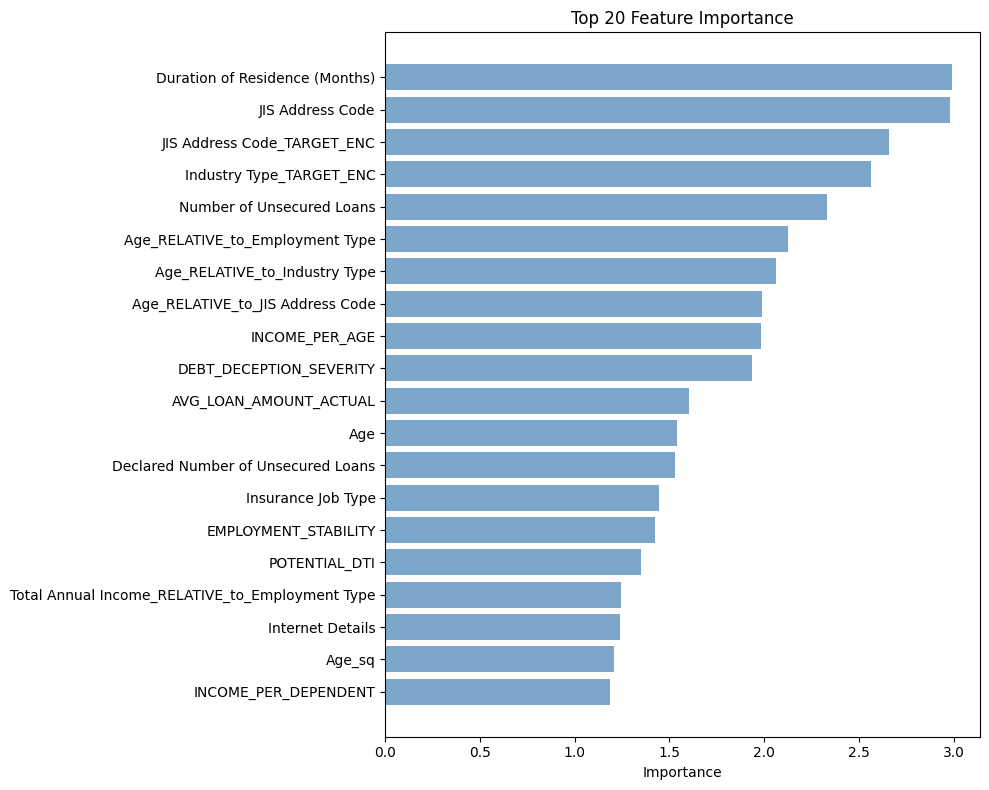

In [229]:
feature_importance = models[0].get_feature_importance()
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Top 20 Features:")
print(importance_df.head(20))

plt.figure(figsize=(10, 8))
top20 = importance_df.head(20)
plt.barh(range(len(top20)), top20['Importance'].values, color='steelblue', alpha=0.7)
plt.yticks(range(len(top20)), top20['Feature'].values)
plt.xlabel('Importance')
plt.title('Top 20 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
